# Extracting Embedding from Amplyfy

In [ ]:
# First time loading the model and tokenizer with huggingface transformers
import os
import json  
import torch
import logging
from transformers import AutoModel, AutoTokenizer


logging.basicConfig(level=logging.INFO)

def model_fn(model_dir):
    """
    This function loads the AMPLIFY model and tokenizer.
    The model is moved to the GPU to support Flash Attention.
    """
    logging.info("[custom] model_fn: Starting the model loading process...")

    try:
        model_id = os.getenv('AMPLIFY_MODEL_ID', 'chandar-lab/AMPLIFY_120M')
        logging.info(f"[custom] model_fn: Model id is {model_id}")

        model = AutoModel.from_pretrained(model_id, trust_remote_code=True)
        logging.info(f"[custom] model_fn: Successfully loaded the model: {model}")

        tokenizer = AutoTokenizer.from_pretrained(model_id, trust_remote_code=True)
        logging.info(f"[custom] model_fn: Successfully loaded the tokenizer: {tokenizer}")

        device = "cuda" if torch.cuda.is_available() else "cpu"
        model = model.to(device)
        logging.info(f"[custom] model_fn: Moved model to {device} device")

        return model, tokenizer, device

    except Exception as e:
        
        logging.error(f"[custom] model_fn: Error occurred while loading the model and tokenizer: {str(e)}", exc_info=True)
        raise e  


model, tokenizer, device = model_fn('AMPLIFY_120M')

## Moving the model to a specific folder to be loaded from any server

In [25]:
# find the path of the model
from pathlib import Path
from huggingface_hub import snapshot_download
path = Path(snapshot_download(repo_id="chandar-lab/AMPLIFY_350M"))
print(path)

Fetching 10 files: 100%|██████████| 10/10 [00:00<00:00, 5255.36it/s]

/stor/home/lcv454/.cache/huggingface/hub/models--chandar-lab--AMPLIFY_350M/snapshots/a735ae820dbf73d7c770623d70cee565038e0f68


In [ ]:
# MOve the model a local directory
#cp /stor/home/lcv454/.cache/huggingface/hub/models--chandar-lab--AMPLIFY_350M/snapshots/a735ae820dbf73d7c770623d70cee565038e0f68/* /stor/work/Wilke/luiz/AMPLIFY/amplify_checkpoints/AMPLIFY_350M

In [42]:
import torch
from transformers import AutoModel, AutoTokenizer

model_checkpoint = "../AMPLIFY/amplify_checkpoints/AMPLIFY_120M"

model = AutoModel.from_pretrained(model_checkpoint, trust_remote_code=True)
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, trust_remote_code=True)

model.eval()

AMPLIFY(
  (encoder): Embedding(27, 640, padding_idx=0)
  (transformer_encoder): ModuleList(
    (0-23): 24 x EncoderBlock(
      (q): Linear(in_features=640, out_features=640, bias=False)
      (k): Linear(in_features=640, out_features=640, bias=False)
      (v): Linear(in_features=640, out_features=640, bias=False)
      (wo): Linear(in_features=640, out_features=640, bias=False)
      (resid_dropout): Dropout(p=0, inplace=False)
      (ffn): SwiGLU(
        (w12): Linear(in_features=640, out_features=3424, bias=False)
        (w3): Linear(in_features=1712, out_features=640, bias=False)
      )
      (attention_norm): RMSNorm()
      (ffn_norm): RMSNorm()
      (ffn_dropout): Dropout(p=0, inplace=False)
    )
  )
  (layer_norm_2): RMSNorm()
  (decoder): Linear(in_features=640, out_features=27, bias=True)
)

In [43]:
# Move the model to GPU (required due to Flash Attention)
device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)
model

AMPLIFY(
  (encoder): Embedding(27, 640, padding_idx=0)
  (transformer_encoder): ModuleList(
    (0-23): 24 x EncoderBlock(
      (q): Linear(in_features=640, out_features=640, bias=False)
      (k): Linear(in_features=640, out_features=640, bias=False)
      (v): Linear(in_features=640, out_features=640, bias=False)
      (wo): Linear(in_features=640, out_features=640, bias=False)
      (resid_dropout): Dropout(p=0, inplace=False)
      (ffn): SwiGLU(
        (w12): Linear(in_features=640, out_features=3424, bias=False)
        (w3): Linear(in_features=1712, out_features=640, bias=False)
      )
      (attention_norm): RMSNorm()
      (ffn_norm): RMSNorm()
      (ffn_dropout): Dropout(p=0, inplace=False)
    )
  )
  (layer_norm_2): RMSNorm()
  (decoder): Linear(in_features=640, out_features=27, bias=True)
)

In [44]:
target_sequence1=["MAACGGAAAE" *300]
target_sequence3=["MAACGGAAA", "MAACGGAAA", "MAACGGAAA"]
target_sequence3d=["MAACGGAAA", "MAACMAACGGAAAGGAAA", "MAACGGAAATTTDDDDFGHHIIIILLLLCCCCC"]

#target_sequences=['MA'*1000, 'MA'*1000, 'MA'*1000]

#max_length = 2048
tokens = tokenizer(target_sequence3, return_tensors="pt", padding=False, truncation=False)
#tokens = tokens['input_ids']
tokens = tokens.to(device)

In [ ]:
# sequences=["MAACGGAAA", "MAACGGAAA", "MAACGGAAA"]
# tokens = tokenizer(sequences, return_tensors="pt", padding=True, truncation=True).to(device)
# tokens['attention_mask'] = tokens['attention_mask'].float()
# with torch.no_grad():
#     output = model(input_ids = tokens['input_ids'],attention_mask = tokens['attention_mask'],output_hidden_states=True)

In [5]:
with torch.no_grad():
    output = model(
        input_ids=tokens['input_ids'],
        output_hidden_states=True
    )

print(output.hidden_states[-1][0].shape)
print(output.logits.shape)
output.hidden_states[-1][0] 

torch.Size([11, 640])
torch.Size([3, 11, 27])


tensor([[ 17.5876, -61.8125,  -4.4285,  ..., 182.0334, -26.3103,  23.8771],
        [-12.8695, -88.9725, -30.6273,  ..., 143.5040, -22.9563, 106.3776],
        [ 28.3378, -46.7837, -10.9481,  ..., 274.8617, -62.8310,  13.2529],
        ...,
        [ 28.8313, -67.2641,  -2.5124,  ..., 243.5236, -69.9578,  15.2974],
        [ 31.9428, -69.1148,  -4.0000,  ..., 239.9025, -72.9473,  13.0227],
        [ 24.7427, -68.5901,  -0.4530,  ..., 182.1644, -31.1259,  68.7758]],
       device='cuda:0')

In [4]:
output = model(input_ids=tokens['input_ids'],output_hidden_states=True)
print(output.hidden_states[-1][0].shape)
print(output.logits.shape)
output.hidden_states[-1][0] 

torch.Size([11, 640])
torch.Size([3, 11, 27])


tensor([[ 17.5876, -61.8125,  -4.4285,  ..., 182.0334, -26.3103,  23.8771],
        [-12.8695, -88.9725, -30.6273,  ..., 143.5040, -22.9563, 106.3776],
        [ 28.3378, -46.7837, -10.9481,  ..., 274.8617, -62.8310,  13.2529],
        ...,
        [ 28.8313, -67.2641,  -2.5124,  ..., 243.5236, -69.9578,  15.2974],
        [ 31.9428, -69.1148,  -4.0000,  ..., 239.9025, -72.9473,  13.0227],
        [ 24.7427, -68.5901,  -0.4530,  ..., 182.1644, -31.1259,  68.7758]],
       device='cuda:0', grad_fn=<SelectBackward0>)

In [ ]:
# first residue of the logits with 1 seq in the tensor
torch.Size([1, 11, 27])
tensor([-6.9433, -6.9415, -6.9405, -6.9425, -6.9420, -4.0011, 13.6057, 15.6271,
        14.8239, 13.8504, 13.4298, 12.9461, 14.7986, 13.1960, 11.4989, 13.2050,
        14.5257, 11.6072, 11.9029, 11.0428, 11.7239, 10.7854, 13.7575, 12.3320,
        11.9455, 13.1014, -6.9426], device='cuda:0', grad_fn=<SelectBackward0>)

# first residue of the logits with 3 seqs of the same length in the tensor
torch.Size([3, 11, 27])
tensor([-6.9433, -6.9415, -6.9405, -6.9425, -6.9420, -4.0011, 13.6057, 15.6271,
        14.8239, 13.8504, 13.4298, 12.9461, 14.7986, 13.1960, 11.4989, 13.2050,
        14.5257, 11.6072, 11.9029, 11.0428, 11.7239, 10.7854, 13.7575, 12.3320,
        11.9455, 13.1014, -6.9426], device='cuda:0', grad_fn=<SelectBackward0>)

# first residue of the logits with 3 seqs with different length in the tensor
torch.Size([3, 35, 27])
tensor([-8.4201, -8.4178, -8.4172, -8.4191, -8.4188, -5.1909, 12.4360, 14.2308,
        13.4908, 12.5516, 12.4136, 11.9722, 13.6079, 12.1095, 10.8088, 12.2386,
        13.1589, 10.9875, 10.8708, 10.4327, 10.8033,  9.5538, 12.9666, 11.2027,
        10.5151, 11.7893, -8.4192], device='cuda:0', grad_fn=<SelectBackward0>)

In [4]:
stop

NameError: name 'stop' is not defined

## Extract embedding from a fasta file

In [8]:
import torch
import pandas as pd
from transformers import AutoModel, AutoTokenizer
from Bio import SeqIO
from tqdm import tqdm

In [23]:
model_checkpoint = "amplify_checkpoints/AMPLIFY_350M"

model = AutoModel.from_pretrained(model_checkpoint, trust_remote_code=True)
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, trust_remote_code=True)
#device = "cuda" if torch.cuda.is_available() else "cpu"
device = "cpu"
model = model.to(device)
print(f'Model transfered to {device}')
model

Model transfered to cpu


AMPLIFY(
  (encoder): Embedding(27, 960, padding_idx=0)
  (transformer_encoder): ModuleList(
    (0-31): 32 x EncoderBlock(
      (q): Linear(in_features=960, out_features=960, bias=False)
      (k): Linear(in_features=960, out_features=960, bias=False)
      (v): Linear(in_features=960, out_features=960, bias=False)
      (wo): Linear(in_features=960, out_features=960, bias=False)
      (resid_dropout): Dropout(p=0, inplace=False)
      (ffn): SwiGLU(
        (w12): Linear(in_features=960, out_features=5120, bias=False)
        (w3): Linear(in_features=2560, out_features=960, bias=False)
      )
      (attention_norm): RMSNorm()
      (ffn_norm): RMSNorm()
      (ffn_dropout): Dropout(p=0, inplace=False)
    )
  )
  (layer_norm_2): RMSNorm()
  (decoder): Linear(in_features=960, out_features=27, bias=True)
)

In [84]:
fasta_file = "data/test.fasta"
fasta_file = "data/test_prot.fasta"

mean_representations = {}
 
sequences = list(SeqIO.parse(fasta_file, "fasta"))
total_seqs = len(sequences)

    
for seq in tqdm(sequences, desc="Processing sequences", leave=False):
    seq_id = seq.id
    sequence = str(seq.seq)
    seq_length = len(sequence)
    tokens = tokenizer(sequence, return_tensors="pt", padding=True, truncation=False)
    tokens = tokens.to(device)
    output = model(tokens['input_ids'], output_hidden_states=True)


    # Determine the hidden size from the model
    hidden_size = model.config.hidden_size if hasattr(model, "config") else None
    # Initialize LayerNorm and move to correct device
    layer_norm = nn.LayerNorm(hidden_size, elementwise_affine=True).to(device) if hidden_size else None
      
    embeddings = output.hidden_states[-1][0] # last hidden state and first sequence and only sequence in the batch
    #print(embeddings.shape)

     # Apply LayerNorm if initialized
    if layer_norm:
        embeddings = layer_norm(embeddings)

    
    # Extract the last hidden states for the sequence
    representations =  embeddings[1:seq_length+1, :].detach().to('cpu') 
    # compute mean representation of the sequence
    mean_representations[seq_id] = (representations.mean(dim=0))
    
len(mean_representations.keys())

100

In [85]:
mean_representations
pd.DataFrame(mean_representations).T

,0,1,2,3,4,5,6,7,8,9,...,950,951,952,953,954,955,956,957,958,959
prot0,0.42062,-0.028725,-0.193344,-0.096374,0.223103,0.667636,-0.004177,0.472779,0.786578,0.359791,...,0.025775,0.28138,0.228299,0.097535,-0.428465,0.831539,1.494628,1.08288,-1.05559,0.507
prot1,0.42062,-0.028725,-0.193344,-0.096374,0.223103,0.667636,-0.004177,0.472779,0.786578,0.359791,...,0.025775,0.28138,0.228299,0.097535,-0.428465,0.831539,1.494628,1.08288,-1.05559,0.507
prot2,0.42062,-0.028725,-0.193344,-0.096374,0.223103,0.667636,-0.004177,0.472779,0.786578,0.359791,...,0.025775,0.28138,0.228299,0.097535,-0.428465,0.831539,1.494628,1.08288,-1.05559,0.507
prot3,0.42062,-0.028725,-0.193344,-0.096374,0.223103,0.667636,-0.004177,0.472779,0.786578,0.359791,...,0.025775,0.28138,0.228299,0.097535,-0.428465,0.831539,1.494628,1.08288,-1.05559,0.507
prot4,0.42062,-0.028725,-0.193344,-0.096374,0.223103,0.667636,-0.004177,0.472779,0.786578,0.359791,...,0.025775,0.28138,0.228299,0.097535,-0.428465,0.831539,1.494628,1.08288,-1.05559,0.507
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
prot95,0.42062,-0.028725,-0.193344,-0.096374,0.223103,0.667636,-0.004177,0.472779,0.786578,0.359791,...,0.025775,0.28138,0.228299,0.097535,-0.428465,0.831539,1.494628,1.08288,-1.05559,0.507
prot96,0.42062,-0.028725,-0.193344,-0.096374,0.223103,0.667636,-0.004177,0.472779,0.786578,0.359791,...,0.025775,0.28138,0.228299,0.097535,-0.428465,0.831539,1.494628,1.08288,-1.05559,0.507
prot97,0.42062,-0.028725,-0.193344,-0.096374,0.223103,0.667636,-0.004177,0.472779,0.786578,0.359791,...,0.025775,0.28138,0.228299,0.097535,-0.428465,0.831539,1.494628,1.08288,-1.05559,0.507
prot98,0.42062,-0.028725,-0.193344,-0.096374,0.223103,0.667636,-0.004177,0.472779,0.786578,0.359791,...,0.025775,0.28138,0.228299,0.097535,-0.428465,0.831539,1.494628,1.08288,-1.05559,0.507


In [110]:
def extract_mean_representations(model, tokenizer, fasta_file, device="cpu"):

    mean_representations = {}
 
    sequences = SeqIO.parse(fasta_file, "fasta")
    #total_seqs = len(sequences)

    for seq in tqdm(sequences, desc="Processing sequences", leave=False):
        seq_id = seq.id
        sequence = str(seq.seq)
        seq_length = len(sequence)
        tokens = tokenizer(sequence, return_tensors="pt", padding=True, truncation=False)
        tokens = tokens.to(device)
        output = model(tokens['input_ids'], output_hidden_states=True)


        # Determine the hidden size from the model
        hidden_size = model.config.hidden_size if hasattr(model, "config") else None
        # Initialize LayerNorm and move to correct device
        layer_norm = nn.LayerNorm(hidden_size, elementwise_affine=True).to(device) if hidden_size else None
        
        embeddings = output.hidden_states[-1][0] # last hidden state and first sequence and only sequence in the batch

        # Apply LayerNorm if initialized
        if layer_norm:
            embeddings = layer_norm(embeddings)

        # Extract the last hidden states for the sequence
        representations =  embeddings[1:seq_length+1, :].detach().to('cpu') 
        # compute mean representation of the sequence
        mean_representations[seq_id] = (representations.mean(dim=0))
    
    return mean_representations

In [24]:
class FastaDataLoader:
    """
    Data loader for reading a FASTA file and returning batches of sequence IDs, lengths, and tokenized sequences.
    Designed to work with tqdm.
    
    Args:
    - fasta_file (str): Path to the FASTA file.
    - batch_size (int): Number of sequences per batch.
    - model (object): Model object with a `_tokenize` method for tokenizing sequences.
    """
    def __init__(self, fasta_file, batch_size, tokenizer):
        self.fasta_file = fasta_file
        self.batch_size = batch_size
        self.tokenizer=tokenizer
        self.sequences = list(SeqIO.parse(fasta_file, "fasta"))
        self.total = len(self.sequences)

    def __len__(self):
        return (self.total + self.batch_size - 1) // self.batch_size

    def __iter__(self):
        ids, lengths, seqs = [], [], []
        for seq in self.sequences:
            ids.append(seq.id)
            lengths.append(len(seq.seq))
            seqs.append(str(seq.seq))
            
            if len(ids) == self.batch_size:
                tokens = self.tokenizer(seqs, return_tensors="pt", padding=True, truncation=False)
                tokens = tokens['input_ids']
                yield ids, lengths, tokens
                ids, lengths, seqs = [], [], []

        # Yield any remaining sequences if they don't fill the last batch
        if ids:
            tokens = self.tokenizer(seqs, return_tensors="pt", padding=True, truncation=False)
            tokens = tokens['input_ids']
            yield ids, lengths, tokens

In [ ]:
def extract_mean_representations1(model, tokenizer, fasta_file, batch_size=2, device="cpu"):

    mean_representations = {}
    data_loader = FastaDataLoader(fasta_file, batch_size=batch_size, tokenizer=tokenizer)
    
    for batch_ids, batch_lengths, batch_tokens in tqdm(data_loader, desc="Processing batches", leave=False):
        batch_tokens = batch_tokens.to(device)
        output = model(batch_tokens, output_hidden_states=True)
      
        embeddings = output.hidden_states[-1]
       
        for i, ID in enumerate(batch_ids):
        # Extract the last hidden states for the sequence
            representations =  embeddings[i, 1:batch_lengths[i]+1, :].detach().to('cpu') 
            # compute mean representation of the sequence
            mean_representations[ID] = (representations.mean(dim=0))
    
    return mean_representations

In [25]:
def extract_mean_representations1(model, tokenizer, fasta_file, batch_size=2, device="cpu"):

    mean_representations = {}
    data_loader = FastaDataLoader(fasta_file, batch_size=batch_size, tokenizer=tokenizer)
    
    for batch_ids, batch_lengths, batch_tokens in tqdm(data_loader, desc="Processing batches", leave=False):
        batch_tokens = batch_tokens.to(device)
        output = model(batch_tokens, output_hidden_states=True)
      
        embeddings = output.hidden_states[-1]
       
        for i, ID in enumerate(batch_ids):
        # Extract the last hidden states for the sequence
            representations =  embeddings[i, 1:batch_lengths[i]+1, :].detach().to('cpu') 
            # compute mean representation of the sequence
            mean_representations[ID] = (representations.mean(dim=0))
    
    return mean_representations



In [27]:
import torch.nn as nn

def extract_mean_representations2(model, tokenizer, fasta_file, batch_size=2, device="cpu"):
    """
    Extracts mean representations for sequences in a FASTA file using the last hidden layer
    of a model, applying LayerNorm or RMSNorm to the last hidden layer.

    Args:
        model: The model to extract embeddings from.
        tokenizer: The tokenizer to process the sequences.
        fasta_file: Path to the FASTA file.
        batch_size: Number of sequences per batch.
        device: Device to run computations on (e.g., "cpu" or "cuda").

    Returns:
        A dictionary with sequence IDs as keys and their mean representations as values.
    """
    mean_representations = {}
    data_loader = FastaDataLoader(fasta_file, batch_size=batch_size, tokenizer=tokenizer)
    
    # Determine the hidden size from the model
    hidden_size = model.config.hidden_size if hasattr(model, "config") else None
    
    # Initialize LayerNorm and move to correct device
    layer_norm = nn.LayerNorm(hidden_size, elementwise_affine=True).to(device) if hidden_size else None
    
    for batch_ids, batch_lengths, batch_tokens in tqdm(data_loader, desc="Processing batches", leave=False):
        batch_tokens = batch_tokens.to(device)  # Ensure tokens are on the correct device
        output = model(batch_tokens, output_hidden_states=True)
      
        embeddings = output.hidden_states[-1]  # Extract the last hidden layer
        
        # Apply LayerNorm if initialized
        if layer_norm:
            embeddings = layer_norm(embeddings)

        for i, ID in enumerate(batch_ids):
            # Extract the normalized last hidden states for the sequence
            representations = embeddings[i, 1:batch_lengths[i] + 1, :].detach().to('cpu') 
            # Compute the mean representation of the sequence
            mean_representations[ID] = representations.mean(dim=0)
    
    return mean_representations


In [112]:
fasta_file = 'data/test.fasta'

embeds = extract_mean_representations(model, tokenizer, fasta_file, device=device)
pd.DataFrame(embeds).T


,0,1,2,3,4,5,6,7,8,9,...,950,951,952,953,954,955,956,957,958,959
prot1,-0.288050,-0.015999,0.310711,0.133730,0.638179,2.450508,0.096535,-0.476899,-0.204502,-0.001740,...,-0.071974,0.630279,-0.369676,-0.691108,-0.348698,-0.188466,1.820525,0.725534,-0.216046,-0.083576
prot2,0.216729,0.374200,0.143336,0.342890,-0.060334,1.546719,0.580836,0.277752,0.520905,-0.156866,...,-0.515292,0.184864,-0.254127,0.391351,-0.538047,0.257708,1.405552,1.446408,-0.840988,0.279102
prot3,0.226525,0.641646,0.143757,0.139268,0.024070,1.219716,0.144139,0.235365,0.532596,-0.222743,...,-0.243540,-0.100204,-0.500026,0.366509,-1.003191,0.389825,1.775406,1.312901,-1.017334,0.278426
prot4,0.196374,0.369262,0.245913,0.343545,0.036515,1.423345,0.311948,0.293229,0.395353,-0.179454,...,-0.254454,0.278693,-0.467219,0.184757,-0.721530,0.236504,1.434328,1.258763,-0.732515,0.288526


In [ ]:
embeds = extract_mean_representations2(model, tokenizer, fasta_file, batch_size=4, device=device)
pd.DataFrame(embeds).T

## Merging AMPLiFY embeddings

In [34]:
import torch
import pandas as pd

## PISCES

In [38]:
model = 'amplify_350M_no_layernorm'

embed1 = torch.load(f'embeddings/PISCES_compressed/{model}/pisces_len64-1022_1.pt', weights_only=True)
embed2 = torch.load(f'embeddings/PISCES_compressed/{model}/pisces_len64-1022_2.pt', weights_only=True)

embed1.update(embed2)

torch.save(embed1, f'embeddings/PISCES_compressed/{model}/embed_pisces_mean.pt')

In [39]:
embed = torch.load(f'embeddings/PISCES_compressed/{model}/embed_pisces_mean.pt' , weights_only=True)
len(set(embed.keys()))

23487

In [40]:
df = pd.DataFrame.from_dict(embed).T.reset_index()
df.rename(columns={'index': 'ID'}, inplace=True)
df.shape
df.head()

,ID,0,1,2,3,4,5,6,7,8,...,950,951,952,953,954,955,956,957,958,959
0,5D8VA,-27.671734,13.516710,14.413445,14.410961,8.176245,82.163124,13.276825,2.314362,2.799994,...,-9.134468,-0.055495,-13.938244,20.213303,-57.038216,19.017113,137.775558,50.667152,-47.343536,-1.097889
1,1UCSA,8.416983,62.522270,16.854404,41.832378,12.638750,170.159973,7.279777,-15.715260,46.584320,...,-47.408947,-38.162037,-54.992527,42.208652,-115.479713,71.445107,349.612061,150.100586,-172.911148,3.701025
2,3X2MA,12.589259,40.452446,27.487291,22.523102,30.700888,101.439743,3.647077,9.928739,10.984908,...,-35.492813,-7.033830,-26.173727,32.058739,-63.511925,35.707394,203.927078,75.886475,-70.005302,14.122482
3,2VB1A,11.536150,7.980748,17.855190,6.804742,-0.575112,44.309067,12.857036,-7.512388,20.599066,...,-5.698743,-11.514664,-4.901938,-0.050233,-34.147991,8.156175,84.887444,18.014685,-26.396168,0.767295
4,1US0A,4.128558,2.655105,6.339581,16.998310,5.209182,61.620705,12.572465,-6.768964,15.962422,...,-17.448774,10.501692,-17.118235,1.543883,-28.988665,9.005565,72.499062,26.381567,-25.815702,-8.508069


In [41]:
meta_data = pd.read_csv('data/PISCES_metadata/PCP.csv')
meta_data

,ID,PDB_ID,Chain,sequence,len,method,resol,rfac,freerfac,Instability_index,...,M_freq,N_freq,P_freq,Q_freq,R_freq,S_freq,T_freq,V_freq,W_freq,Y_freq
0,5D8VA,5D8V,A,AAPANAVTADDPTAIALKYNQDATKSERVAAARPGLPPEEQHCANC...,83,XRAY,0.48,0.072,0.078,20.67,...,0.012048,0.072289,0.072289,0.060241,0.024096,0.024096,0.048193,0.048193,0.036145,0.012048
1,3NIRA,3NIR,A,TTCCPSIVARSNFNVCRLPGTPEALCATYTGCIIIPGATCPGDYAN,46,XRAY,0.48,0.127,NaN,31.89,...,0.000000,0.065217,0.108696,0.000000,0.043478,0.043478,0.130435,0.043478,0.000000,0.043478
2,5NW3A,5NW3,A,MAKWVCKICGYIYDEDAGDPDNGISPGTKFEELPDDWVCPICGAPK...,54,XRAY,0.59,0.135,0.146,33.91,...,0.018519,0.018519,0.092593,0.000000,0.000000,0.037037,0.018519,0.037037,0.037037,0.037037
3,1UCSA,1UCS,A,NKASVVANQLIPINTALTLIMMKAEVVTPMGIPAEEIPKLVGMQVN...,64,XRAY,0.62,0.139,0.155,17.25,...,0.093750,0.078125,0.093750,0.031250,0.015625,0.015625,0.078125,0.125000,0.000000,0.015625
4,3X2MA,3X2M,A,ATGGYVQQATGQASFTMYSGCGSPACGKAASGFTAAINQLAFGSAP...,180,XRAY,0.64,0.122,0.129,39.45,...,0.011111,0.050000,0.066667,0.061111,0.005556,0.088889,0.100000,0.033333,0.016667,0.022222
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24018,8HDDB,8HDD,B,MGKSTLTFLIAGCLALPGFARAADAADPALVKRGEYLATAGDCMAC...,482,XRAY,3.00,0.278,0.323,39.02,...,0.026971,0.037344,0.076763,0.041494,0.045643,0.056017,0.051867,0.070539,0.020747,0.037344
24019,5C6PA,5C6P,A,LDRFSFSVFLKEIRLLTALALPMLLAQVAQVGIGFVDTVMAGGAGK...,459,XRAY,3.00,0.280,0.290,24.34,...,0.041394,0.013072,0.037037,0.023965,0.034858,0.071895,0.041394,0.076253,0.023965,0.041394
24020,4LIDB,4LID,B,MVSPQTRKEEELLEKQNSVFYLLTLGRKPYGSYLHIKIELDEDEKL...,106,XRAY,3.00,0.286,0.251,51.23,...,0.009434,0.028302,0.018868,0.056604,0.037736,0.047170,0.028302,0.047170,0.000000,0.056604
24021,1ZP2A,1ZP2,A,YWASSQLTQLFLSTDLESLEPTCLSKDTIYQWKVVQTFGDRLRLRQ...,235,XRAY,3.00,0.290,0.288,42.93,...,0.008511,0.034043,0.021277,0.042553,0.038298,0.085106,0.046809,0.055319,0.017021,0.038298


In [42]:
data = meta_data.merge(df, how='inner', left_on='ID', right_on='ID')
data

,ID,PDB_ID,Chain,sequence,len,method,resol,rfac,freerfac,Instability_index,...,950,951,952,953,954,955,956,957,958,959
0,5D8VA,5D8V,A,AAPANAVTADDPTAIALKYNQDATKSERVAAARPGLPPEEQHCANC...,83,XRAY,0.48,0.072,0.078,20.67,...,-9.134468,-0.055495,-13.938244,20.213303,-57.038216,19.017113,137.775558,50.667152,-47.343536,-1.097889
1,1UCSA,1UCS,A,NKASVVANQLIPINTALTLIMMKAEVVTPMGIPAEEIPKLVGMQVN...,64,XRAY,0.62,0.139,0.155,17.25,...,-47.408947,-38.162037,-54.992527,42.208652,-115.479713,71.445107,349.612061,150.100586,-172.911148,3.701025
2,3X2MA,3X2M,A,ATGGYVQQATGQASFTMYSGCGSPACGKAASGFTAAINQLAFGSAP...,180,XRAY,0.64,0.122,0.129,39.45,...,-35.492813,-7.033830,-26.173727,32.058739,-63.511925,35.707394,203.927078,75.886475,-70.005302,14.122482
3,2VB1A,2VB1,A,KVFGRCELAAAMKRHGLDNYRGYSLGNWVCAAKFESNFNTQATNRN...,129,XRAY,0.65,0.084,0.095,16.09,...,-5.698743,-11.514664,-4.901938,-0.050233,-34.147991,8.156175,84.887444,18.014685,-26.396168,0.767295
4,1US0A,1US0,A,MASRILLNNGAKMPILGLGTWKSPPGQVTEAVKVAIDVGYRHIDCA...,316,XRAY,0.66,0.094,0.103,37.19,...,-17.448774,10.501692,-17.118235,1.543883,-28.988665,9.005565,72.499062,26.381567,-25.815702,-8.508069
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23180,8HDDB,8HDD,B,MGKSTLTFLIAGCLALPGFARAADAADPALVKRGEYLATAGDCMAC...,482,XRAY,3.00,0.278,0.323,39.02,...,-5.228457,1.509603,1.518183,15.817743,-42.798042,6.600604,87.157318,28.300133,-38.289795,-7.204808
23181,5C6PA,5C6P,A,LDRFSFSVFLKEIRLLTALALPMLLAQVAQVGIGFVDTVMAGGAGK...,459,XRAY,3.00,0.280,0.290,24.34,...,-2.938820,-1.243987,-1.618691,3.530603,-16.375916,9.321518,52.926418,-3.447061,-25.768774,-5.680083
23182,4LIDB,4LID,B,MVSPQTRKEEELLEKQNSVFYLLTLGRKPYGSYLHIKIELDEDEKL...,106,XRAY,3.00,0.286,0.251,51.23,...,-26.322899,-11.393445,-67.235031,43.785950,-122.409805,66.781860,321.605347,160.783234,-165.990646,13.437518
23183,1ZP2A,1ZP2,A,YWASSQLTQLFLSTDLESLEPTCLSKDTIYQWKVVQTFGDRLRLRQ...,235,XRAY,3.00,0.290,0.288,42.93,...,-14.791146,7.921321,-19.536602,23.886755,-70.306091,25.841869,217.517090,87.317970,-97.317993,-14.429244


In [43]:
stop

NameError: name 'stop' is not defined

## HIS7

In [2]:
model = 'amplify_350M'

embed1 = torch.load(f'embeddings/HIS7_compressed/{model}/HIS7_part1.1.pt', weights_only=True)
embed2 = torch.load(f'embeddings/HIS7_compressed/{model}/HIS7_part1.2.pt', weights_only=True)
embed3 = torch.load(f'embeddings/HIS7_compressed/{model}/HIS7_part2.1.pt', weights_only=True)
embed4 = torch.load(f'embeddings/HIS7_compressed/{model}/HIS7_part2.2.pt', weights_only=True)

embed1.update(embed2)
embed1.update(embed3)
embed1.update(embed4)

torch.save(embed1, f'embeddings/HIS7_compressed/{model}/embed_HIS7_mean.pt')

In [3]:
embed = torch.load(f'embeddings/HIS7_compressed/{model}/embed_HIS7_mean.pt' , weights_only=True)
len(set(embed.keys()))

496137

In [4]:
df = pd.DataFrame.from_dict(embed).T.reset_index()
df

,index,0,1,2,3,4,5,6,7,8,...,950,951,952,953,954,955,956,957,958,959
0,HIS7_YEAST_1,-0.148089,0.217018,0.047511,0.172242,-0.022183,1.233490,0.263247,0.094695,0.123729,...,-0.156068,-0.026901,-0.023470,0.187030,-0.324838,0.147229,1.683200,0.614163,-0.817517,-0.109532
1,HIS7_YEAST_2,-0.164458,0.169829,0.041158,0.190332,-0.034719,1.268176,0.277112,0.116552,0.090380,...,-0.164588,-0.039379,-0.007741,0.210420,-0.308238,0.152375,1.655244,0.612088,-0.814571,-0.095796
2,HIS7_YEAST_3,-0.147828,0.215563,0.047999,0.193376,-0.010777,1.237976,0.257389,0.091580,0.132923,...,-0.153303,-0.025705,-0.029494,0.196953,-0.334891,0.161538,1.705032,0.632888,-0.834315,-0.091817
3,HIS7_YEAST_4,-0.150837,0.211734,0.059097,0.185031,-0.016133,1.235561,0.268850,0.096736,0.128189,...,-0.149192,-0.025343,-0.026386,0.186207,-0.338574,0.162137,1.698558,0.639802,-0.839633,-0.099880
4,HIS7_YEAST_5,-0.153518,0.206220,0.044118,0.206798,-0.032248,1.245296,0.262883,0.096736,0.111177,...,-0.157057,-0.021661,-0.020775,0.205451,-0.337202,0.160028,1.681549,0.627155,-0.817218,-0.091632
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
496132,HIS7_YEAST_496133,-0.141916,0.205020,0.044980,0.184506,-0.043978,1.244694,0.273205,0.108530,0.118877,...,-0.168589,-0.050924,-0.004507,0.203240,-0.353373,0.148506,1.668231,0.610838,-0.834815,-0.109681
496133,HIS7_YEAST_496134,-0.147311,0.204181,0.051837,0.174612,-0.037388,1.244724,0.273207,0.105468,0.085255,...,-0.164566,-0.040827,-0.002948,0.182205,-0.326417,0.159603,1.656922,0.597476,-0.825031,-0.117797
496134,HIS7_YEAST_496135,-0.139439,0.187908,0.051108,0.182188,-0.040491,1.278236,0.277778,0.107113,0.071678,...,-0.157248,-0.049599,-0.004700,0.190433,-0.332475,0.157290,1.588768,0.606772,-0.806873,-0.114691
496135,HIS7_YEAST_496136,-0.178428,0.188620,0.050058,0.187611,-0.043393,1.273721,0.281037,0.109667,0.077648,...,-0.173497,-0.045940,-0.013592,0.189791,-0.335988,0.166571,1.641040,0.614091,-0.819582,-0.119213


In [5]:
meta_data = pd.read_csv('data/HIS7_metadata/HIS7_YEAST_Kondrashov2017_metadata.csv', index_col=0)
meta_data

,ID,mutant,target,sequence
0,HIS7_YEAST_1,S136C:N137D:V143I:E144N:I160V:P161T:F163V,0.755495,MTEQKALVKRITNETKIQIAISLKGGPLAIEHSIFPEKEAEAVAEQ...
1,HIS7_YEAST_2,S136C:N137S:P139A:Y140F:A141S:V143I:E144D:I160...,0.475935,MTEQKALVKRITNETKIQIAISLKGGPLAIEHSIFPEKEAEAVAEQ...
2,HIS7_YEAST_3,S136F:N137D:P139A:Y140F:V143I:E144N:I160V:F163V,0.000000,MTEQKALVKRITNETKIQIAISLKGGPLAIEHSIFPEKEAEAVAEQ...
3,HIS7_YEAST_4,S136F:N137D:P139A:V142F:V143T:E144N:C157S:I160...,0.000000,MTEQKALVKRITNETKIQIAISLKGGPLAIEHSIFPEKEAEAVAEQ...
4,HIS7_YEAST_5,S136F:N137D:P139A:A141C:E144D:I160V:F163I,0.000000,MTEQKALVKRITNETKIQIAISLKGGPLAIEHSIFPEKEAEAVAEQ...
...,...,...,...,...
496132,HIS7_YEAST_496133,A6V:L7S:K9R:A20S:I21L:S22C:L23I,0.970580,MTEQKVSVRRITNETKIQISLCIKGGPLAIEHSIFPEKEAEAVAEQ...
496133,HIS7_YEAST_496134,A6V:L7S:K9R:I11N:S22G:K24N,0.893046,MTEQKVSVRRNTNETKIQIAIGLNGGPLAIEHSIFPEKEAEAVAEQ...
496134,HIS7_YEAST_496135,A6V:L7S:K9R:I11N:I19V:I21L,1.159665,MTEQKVSVRRNTNETKIQVALSLKGGPLAIEHSIFPEKEAEAVAEQ...
496135,HIS7_YEAST_496136,A6V:L7S:K9S:I11D:A20S:I21L:S22G:K24N,0.876360,MTEQKVSVSRDTNETKIQISLGLNGGPLAIEHSIFPEKEAEAVAEQ...


In [6]:
df.rename(columns={'index': 'ID'}, inplace=True)

data = meta_data.merge(df, how='inner', left_on='ID', right_on='ID')
data

,ID,mutant,target,sequence,0,1,2,3,4,5,...,950,951,952,953,954,955,956,957,958,959
0,HIS7_YEAST_1,S136C:N137D:V143I:E144N:I160V:P161T:F163V,0.755495,MTEQKALVKRITNETKIQIAISLKGGPLAIEHSIFPEKEAEAVAEQ...,-0.148089,0.217018,0.047511,0.172242,-0.022183,1.233490,...,-0.156068,-0.026901,-0.023470,0.187030,-0.324838,0.147229,1.683200,0.614163,-0.817517,-0.109532
1,HIS7_YEAST_2,S136C:N137S:P139A:Y140F:A141S:V143I:E144D:I160...,0.475935,MTEQKALVKRITNETKIQIAISLKGGPLAIEHSIFPEKEAEAVAEQ...,-0.164458,0.169829,0.041158,0.190332,-0.034719,1.268176,...,-0.164588,-0.039379,-0.007741,0.210420,-0.308238,0.152375,1.655244,0.612088,-0.814571,-0.095796
2,HIS7_YEAST_3,S136F:N137D:P139A:Y140F:V143I:E144N:I160V:F163V,0.000000,MTEQKALVKRITNETKIQIAISLKGGPLAIEHSIFPEKEAEAVAEQ...,-0.147828,0.215563,0.047999,0.193376,-0.010777,1.237976,...,-0.153303,-0.025705,-0.029494,0.196953,-0.334891,0.161538,1.705032,0.632888,-0.834315,-0.091817
3,HIS7_YEAST_4,S136F:N137D:P139A:V142F:V143T:E144N:C157S:I160...,0.000000,MTEQKALVKRITNETKIQIAISLKGGPLAIEHSIFPEKEAEAVAEQ...,-0.150837,0.211734,0.059097,0.185031,-0.016133,1.235561,...,-0.149192,-0.025343,-0.026386,0.186207,-0.338574,0.162137,1.698558,0.639802,-0.839633,-0.099880
4,HIS7_YEAST_5,S136F:N137D:P139A:A141C:E144D:I160V:F163I,0.000000,MTEQKALVKRITNETKIQIAISLKGGPLAIEHSIFPEKEAEAVAEQ...,-0.153518,0.206220,0.044118,0.206798,-0.032248,1.245296,...,-0.157057,-0.021661,-0.020775,0.205451,-0.337202,0.160028,1.681549,0.627155,-0.817218,-0.091632
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
496132,HIS7_YEAST_496133,A6V:L7S:K9R:A20S:I21L:S22C:L23I,0.970580,MTEQKVSVRRITNETKIQISLCIKGGPLAIEHSIFPEKEAEAVAEQ...,-0.141916,0.205020,0.044980,0.184506,-0.043978,1.244694,...,-0.168589,-0.050924,-0.004507,0.203240,-0.353373,0.148506,1.668231,0.610838,-0.834815,-0.109681
496133,HIS7_YEAST_496134,A6V:L7S:K9R:I11N:S22G:K24N,0.893046,MTEQKVSVRRNTNETKIQIAIGLNGGPLAIEHSIFPEKEAEAVAEQ...,-0.147311,0.204181,0.051837,0.174612,-0.037388,1.244724,...,-0.164566,-0.040827,-0.002948,0.182205,-0.326417,0.159603,1.656922,0.597476,-0.825031,-0.117797
496134,HIS7_YEAST_496135,A6V:L7S:K9R:I11N:I19V:I21L,1.159665,MTEQKVSVRRNTNETKIQVALSLKGGPLAIEHSIFPEKEAEAVAEQ...,-0.139439,0.187908,0.051108,0.182188,-0.040491,1.278236,...,-0.157248,-0.049599,-0.004700,0.190433,-0.332475,0.157290,1.588768,0.606772,-0.806873,-0.114691
496135,HIS7_YEAST_496136,A6V:L7S:K9S:I11D:A20S:I21L:S22G:K24N,0.876360,MTEQKVSVSRDTNETKIQISLGLNGGPLAIEHSIFPEKEAEAVAEQ...,-0.178428,0.188620,0.050058,0.187611,-0.043393,1.273721,...,-0.173497,-0.045940,-0.013592,0.189791,-0.335988,0.166571,1.641040,0.614091,-0.819582,-0.119213


## LayerNorn vs no LayerNorm

In [27]:
import os
import pandas as pd 
import seaborn as sns   

In [39]:
results = pd.DataFrame()

In [40]:
models = ['amplify_120M', 'amplify_120M_no_layernorm', 'amplify_350M', 'amplify_350M_no_layernorm']

for model in models:
    res_dir = f'results/lassoCV/PISCES/{model}'
    for file in os.listdir(res_dir):
        if file.endswith('.csv'):
            res = pd.read_csv(f'{res_dir}/{file}', index_col=0)
            res['LayerNorm'] = 'No' if 'no_layernorm' in model else 'Yes'
            res['Model'] = model
            dataset = file.split('_')[:-3]
            res['Dataset'] = '_'.join(dataset)
            
            res = res[['Dataset', 'Model', 'Fold', 'R2_score_test', 'nun_zero_coefs', 'LayerNorm']]
            results = pd.concat([results, res])
       

results

,Dataset,Model,Fold,R2_score_test,nun_zero_coefs,LayerNorm
0,PCP_Hydrophobicity,amplify_120M,1,0.936427,530,Yes
1,PCP_Hydrophobicity,amplify_120M,2,0.941143,524,Yes
2,PCP_Hydrophobicity,amplify_120M,3,0.935506,524,Yes
3,PCP_Hydrophobicity,amplify_120M,4,0.939326,521,Yes
4,PCP_Hydrophobicity,amplify_120M,5,0.939367,529,Yes
...,...,...,...,...,...,...
0,SS_Coil_amplify_350M,amplify_350M_no_layernorm,1,0.599018,758,No
1,SS_Coil_amplify_350M,amplify_350M_no_layernorm,2,0.596821,756,No
2,SS_Coil_amplify_350M,amplify_350M_no_layernorm,3,0.560853,770,No
3,SS_Coil_amplify_350M,amplify_350M_no_layernorm,4,0.564348,771,No


<Axes: xlabel='R2_score_test', ylabel='Model'>

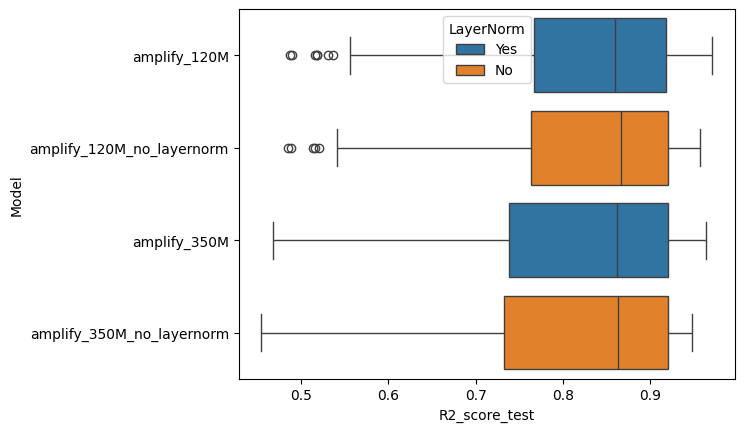

In [41]:
sns.boxplot(y='Model', x='R2_score_test', data=results, hue='LayerNorm')